## ATAC - DNase - EcoDAM Comparison

Let's try to find the overlapping regions of all three methods in a Venn style way. We'll first normalize the EcoDAM data acording to the (smoothed) theoretical value.

In [60]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

import pathlib

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools

from ecodam_py.bedgraph import BedGraphAccessor, equalize_loci
from ecodam_py.eco_atac_normalization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [3]:
dnase = pybedtools.BedTool(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Michael/R/Refrences/Wu_merged_hotspots_as_windows.sort.bed"
)

dnase = (
    dnase.to_dataframe()
    .rename({"chrom": "chr", "start": "start_locus", "end": "end_locus"}, axis=1)
    .reset_index(drop=True)
    .assign(intensity=1)
)
dnase

,chr,start_locus,end_locus,intensity
0,chr1,180739,180871,1
1,chr1,181375,181601,1
2,chr1,268011,268120,1
3,chr1,629084,629310,1
4,chr1,629512,629596,1
...,...,...,...,...
85559,chrY,10994547,10994690,1
85560,chrY,11302660,11302859,1
85561,chrY,11329831,11329998,1
85562,chrY,11494931,11495020,1


<IPython.core.display.Javascript object>

In [4]:
nfr_all_chrom = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/ENCFF240YRV.sorted.bedgraph"
)
nfr_all_chrom = read_bedgraph(nfr_all_chrom)
nfr_all_chrom

,chr,start_locus,end_locus,intensity
0,chr1,0,9950,0
1,chr1,9950,10100,14
2,chr1,10100,10550,0
3,chr1,10550,10700,6
4,chr1,10700,41550,0
...,...,...,...,...
7104909,chrEBV,169600,169650,142
7104910,chrEBV,169650,169700,30
7104911,chrEBV,169700,170650,0
7104912,chrEBV,170650,170750,12


<IPython.core.display.Javascript object>

Now we'll find the intersection of ATAC and DNase, and we'll finally intersect that with our own data:

In [82]:
total_intersection = {}
for overlap_pct in [0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    dnase_intersection, atac_intersection = [], []
    for chr_, dnase_group, atac_group in iter_over_bedgraphs_chromosomes(
        dnase, nfr_all_chrom
    ):
        cur_dnase, cur_atac = dnase_group.bg.weighted_overlap(
            atac_group, overlap_pct=overlap_pct
        )
        #             dnase_intersection.append(cur_dnase.bg.index_to_columns())
        atac_intersection.append(cur_atac.bg.index_to_columns())
    #         dnase_intersection = pd.concat(dnase_intersection, axis=0, ignore_index=True)
    atac_intersection = pd.concat(atac_intersection, axis=0, ignore_index=True)
    total_intersection[overlap_pct] = len(atac_intersection) / len(nfr_all_chrom)
    print(f"Finished {overlap_pct}")

<IPython.core.display.Javascript object>

In [83]:
total_intersection

{0.0001: 0.08592475573947835,
 0.01: 0.08540736735166675,
 0.1: 0.08185151854054813,
 0.2: 0.07949906219836017,
 0.3: 0.07739854416253314,
 0.4: 0.07540274238365165,
 0.5: 0.07339779200705315,
 0.6: 0.07140691639617312,
 0.7: 0.06943532321432744,
 0.8: 0.06744149190264653,
 0.9: 0.06532929181127316,
 0.95: 0.06440556493716884}

<IPython.core.display.Javascript object>

In [47]:
len(dnase_intersection) / len(dnase)

1.0

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ATAC NFR Coverage as a function of overlap requirement with DNase')

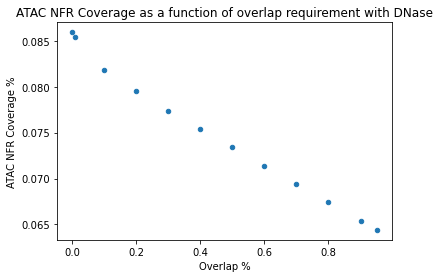

<IPython.core.display.Javascript object>

In [87]:
total_intersection_df = pd.DataFrame.from_dict(
    total_intersection, orient="index", columns=["Overlap percentage requirement"]
)
ax0 = total_intersection_df.reset_index().plot.scatter(
    x="index", y="Overlap percentage requirement"
)
ax0.set_ylabel("ATAC NFR Coverage %")
ax0.set_xlabel("Overlap %")
ax0.set_title("ATAC NFR Coverage as a function of overlap requirement with DNase")

In broad strokes, all DNase areas are covered with ATAC NFR areas, while the DNase only covers about 7% of the NFR. We can check the data on a chromosome-by-chromosome level:

Text(0.5, 1.0, 'ATAC vs DNase overlap')

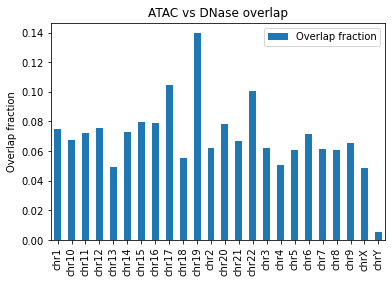

<IPython.core.display.Javascript object>

In [70]:
atac_per_chr = {}
for chr_, dnase_group, atac_group in iter_over_bedgraphs_chromosomes(
    dnase, nfr_all_chrom
):
    dnase_int_grouped = dnase_intersection.query("chr == @chr_")
    atac_int_grouped = atac_intersection.query("chr == @chr_")
    atac_per_chr[chr_] = len(atac_int_grouped) / len(atac_group)

atac_per_chr_df = pd.DataFrame.from_dict(
    atac_per_chr, orient="index", columns=["Overlap fraction"]
)
ax = atac_per_chr_df.plot.bar()
ax.set_ylabel("Overlap fraction")
ax.set_title("ATAC vs DNase overlap")

Not too informative, but definitely reassuring.

## Adding the EcoDAM data

To do that we'll need to normalize that data with the theoretical site density first.

In [2]:
smoothed_theo_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Theoretical_EcoDam/New folder/Hg38.EcoDam.insilico.canonical.keynames.bg_smoothed_7kb_resampled_with_700_overlapping_bp.bedgraph"
)
smoothed_theo = read_bedgraph(smoothed_theo_fname)
smoothed_theo

,chr,start_locus,end_locus,intensity
0,chr1,10598,11298,0.001302
1,chr1,11298,11998,0.002080
2,chr1,11998,12698,0.003104
3,chr1,12698,13398,0.003867
4,chr1,13398,14098,0.003854
...,...,...,...,...
4317590,chr9,138330839,138331539,0.002366
4317591,chr9,138331539,138332239,0.002161
4317592,chr9,138332239,138332939,0.002025
4317593,chr9,138332939,138333639,0.001958


<IPython.core.display.Javascript object>

In [35]:
chromatin = read_bedgraph(
    pathlib.Path(
        "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Michael/Chromatin_rep1/filtered_xmap/pipeline_bedgraphs/NoBlackMask/Chromatin_WholeGenome.bedgraph"
    )
)
chromatin

,chr,start_locus,end_locus,intensity
0,chr2,136500,137500,180.51904
1,chr2,138500,139500,210.61580
2,chr2,139500,140500,262.29640
3,chr2,140500,141500,199.44180
4,chr2,141500,142500,171.83911
...,...,...,...,...
2174836,chrX,155885500,155886500,352.23490
2174837,chrX,155886508,155887508,358.92380
2174838,chrX,155887500,155888500,431.41670
2174839,chrX,155888492,155889492,329.18573


<IPython.core.display.Javascript object>

In [93]:
chrom_intersection, nfr_intersection, dnase_chrom_intersection = [], [], []
for (
    chr_,
    chrom_group,
    theo_group,
    dnase_group,
    nfr_group,
) in iter_over_bedgraphs_chromosomes(chromatin, smoothed_theo, dnase, nfr_all_chrom):
    (
        chrom_even,
        chrom_at_1bp,
        chrom_groups,
        theo_even,
        theo_at_1bp,
        theo_groups,
    ) = equalize_loci(chrom_group.copy(), theo_group.copy())
    # Normalze the chromatin data
    mask, norm_by = prepare_site_density_for_norm(theo_even)
    chrom_even.loc[~mask, "intensity"] *= norm_by
    chrom_even.loc[mask, "intensity"] = 0
    # Find open areas and filter
    chrom_top = chrom_even.intensity.quantile(0.9)
    chrom_top = chrom_even.query("intensity > @chrom_top")
    #         dnase_even, dnase_at_1bp, _, _ = equalize_loci(dnase_group.copy(), theo_group.copy())
    #         nfr_even, nfr_at_1bp, _, _ = equalize_loci(nfr_group.copy(), theo_group.copy())

    try:
        nfr_chrom, cur_nfr = chrom_top.bg.weighted_overlap(nfr_group)
        dnase_chrom, _ = chrom_top.bg.weighted_overlap(dnase_group)
        chrom_intersection.append(nfr_chrom.bg.index_to_columns())
        nfr_intersection.append(cur_nfr.bg.index_to_columns())
        dnase_chrom_intersection.append(dnase_chrom.bg.index_to_columns())
    except AssertionError:
        continue

chrom_intersection = pd.concat(chrom_intersection, axis=0, ignore_index=True)
nfr_intersection = pd.concat(nfr_intersection, axis=0, ignore_index=True)
dnase_chrom_intersection = pd.concat(
    dnase_chrom_intersection, axis=0, ignore_index=True
)

/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'DNase overlap')

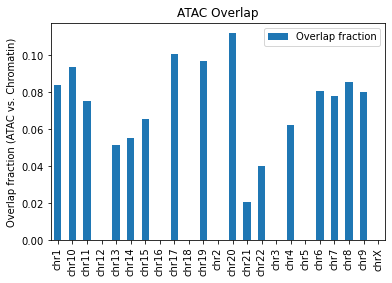

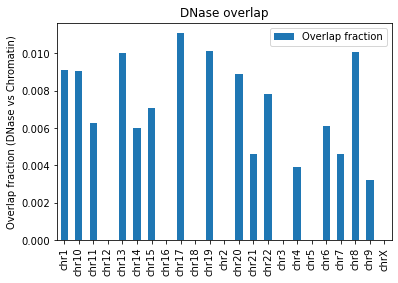

<IPython.core.display.Javascript object>

In [94]:
nfr_per_chr = {}
dnase_nfr = {}
for chr_, chrom_group, nfr_group, dnase_group in iter_over_bedgraphs_chromosomes(
    chromatin, nfr_all_chrom, dnase
):
    nfr_int_grouped = nfr_intersection.query("chr == @chr_")
    nfr_per_chr[chr_] = len(nfr_int_grouped) / len(nfr_group)
    dnase_chrom_int_grouped = dnase_chrom_intersection.query("chr == @chr_")
    dnase_nfr[chr_] = len(dnase_chrom_int_grouped) / len(dnase_group)
nfr_per_chr_df = pd.DataFrame.from_dict(
    nfr_per_chr, orient="index", columns=["Overlap fraction"]
)
ax = nfr_per_chr_df.plot.bar()
ax.set_ylabel("Overlap fraction (ATAC vs. Chromatin)")
ax.set_title("ATAC Overlap")

dnase_chrom_df = pd.DataFrame.from_dict(
    dnase_nfr, orient="index", columns=["Overlap fraction"]
)
axx = dnase_chrom_df.plot.bar()
axx.set_ylabel("Overlap fraction (DNase vs Chromatin)")
axx.set_title("DNase overlap")

<AxesSubplot:>

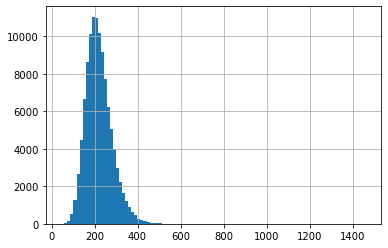

<IPython.core.display.Javascript object>

In [96]:
chromatin.groupby("chr").get_group("chr10").intensity.hist(bins=100)

<AxesSubplot:>

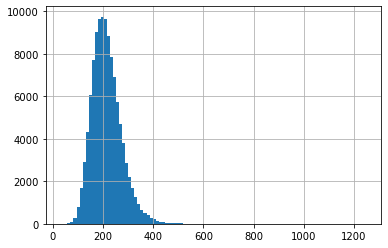

<IPython.core.display.Javascript object>

In [97]:
chromatin.groupby('chr').get_group('chr8').intensity.hist(bins=100)